# Import Modules

In [1]:
%pip install rdkit
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:

import sys
import csv
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from functools import reduce
import operator

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG

import molecule_svg as molsvg
from locate_EAS_sites import locate_sites
from find_atoms import remove_identical_atoms, find_identical_atoms
from reorder_atoms import get_atoms_in_order

In [3]:
# config
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams.update({'font.size': 22})
sns.set()

# Read results into dataframe

In [4]:
def collect_data_to_df(path, measured=True):
    input_file = os.path.join(path, 'compounds.smiles')
    results_file = os.path.join(path, 'compounds.result')
    timing_file = os.path.join(path, 'compounds.timing')

    with open(input_file,'r') as file:
        readCSV = csv.reader(file)
        drugs = {}
        for row in readCSV:
            row = row[0].split()
            name = row[0]
            input_smiles = row[1]

            drugs[name] = {}
            drugs[name]['input_smiles'] = input_smiles
            drugs[name]['measured'] = None
            drugs[name]['taut_names'] = []
            drugs[name]['taut_smiles'] = []
            drugs[name]['taut_energies'] = []
            drugs[name]['taut_status'] = []
            drugs[name]['pred_corr'] = []
            drugs[name]['pred_semi'] = []
            drugs[name]['prot_names'] = []
            drugs[name]['prot_smiles'] = []
            drugs[name]['prot_energies'] = []
            drugs[name]['prot_reaction_center'] = []

    with open(results_file,'r') as file:
        readCSV = csv.reader(file, delimiter=' ')
        drug_tautomers = {}
        for row in readCSV:
            if 'corr' in row or 'semi' in row or 'fail' in row:
                taut_name = row[0]
                name = taut_name.split('_')[0]

                if measured:
                    drugs[name]['measured'] = [int(idx) for idx in ' '.join(row).split('[')[-1].split(']')[0].split(', ')]

                drugs[name]['taut_names'].append(taut_name)
                drugs[name]['taut_status'].append(row[1].capitalize())

                try:
                    pred_corr = [int(idx) for idx in row[-2].split(',')]
                except:
                    pred_corr = []
                drugs[name]['pred_corr'].append(pred_corr)

                try:
                    pred_semi = [int(idx) for idx in row[-1].split(',')]
                except:
                    pred_semi = []
                drugs[name]['pred_semi'].append(pred_semi)
            
            if "info:" in row:
                taut_name = row[2]
                name = taut_name.split('_')[0]
                drugs[name]['taut_smiles'].append(row[3])
                drugs[name]['taut_energies'].append(float(row[4]))


            if "1>" in row or "2>" in row:
                taut_name = row[1].split('+_')[0]
                name = taut_name.split('_')[0]

                if name not in drug_tautomers:
                    drug_tautomers[name] = {}
                
                if taut_name not in drug_tautomers[name]:
                    drug_tautomers[name][taut_name] = {}
                    drug_tautomers[name][taut_name]['prot_names'] = []
                    drug_tautomers[name][taut_name]['prot_smiles'] = []
                    drug_tautomers[name][taut_name]['prot_energies'] = []
                    drug_tautomers[name][taut_name]['prot_reaction_center'] = []
                
                drug_tautomers[name][taut_name]['prot_names'].append(row[1])
                drug_tautomers[name][taut_name]['prot_smiles'].append(row[2])

                energy = float(row[4])
                drug_tautomers[name][taut_name]['prot_energies'].append(energy)

                drug_tautomers[name][taut_name]['prot_reaction_center'].append(row[3])

    for drug in drug_tautomers:
        tautomers = list(drug_tautomers[drug].keys())
        for taut_name in tautomers:
            drugs[drug]['prot_names'].append(drug_tautomers[drug][taut_name]['prot_names'])
            drugs[drug]['prot_smiles'].append(drug_tautomers[drug][taut_name]['prot_smiles'])
            drugs[drug]['prot_energies'].append(drug_tautomers[drug][taut_name]['prot_energies'])
            drugs[drug]['prot_reaction_center'].append(drug_tautomers[drug][taut_name]['prot_reaction_center'])

    with open(timing_file,'r') as file:
        readCSV = csv.reader(file, delimiter=' ')
        for row in readCSV:
            drug = row[0]
            drugs[drug]['time_consumption'] = float(row[3])
    
    return pd.DataFrame(drugs).transpose(), drugs

In [6]:
path = '../example'
df, drugs = collect_data_to_df(path)
df.head()

,input_smiles,measured,taut_names,taut_smiles,taut_energies,taut_status,pred_corr,pred_semi,prot_names,prot_smiles,prot_energies,prot_reaction_center,time_consumption
comp450,[C@H]12C([C@@H]([C@H]([C@@H]3[C@]1(OC(O3)(C)C)...,[16],[comp450_t0],[[C@H]12C([C@H](NC(=O)C=C)[C@@H](c3ccco3)[C@@H...,[-58397.855945962925],[Corr],[[16]],[[16]],[[comp450_t0+_2-2]],[[C=CC(=O)N[C@H]1C2OC(C)(C)O[C@@H]2[C@]2(OC)OC...,[[-83.37173572836036]],[[16]],174.8
comp486,c1(=O)[nH]c(=O)c(n[nH]1)c1ccco1,[11],"[comp486_t0, comp486_t3]","[c1(=O)[nH]c(=O)c(-c2ccco2)n[nH]1, c1(=O)nc(O)...","[-25845.062412246898, -25831.243130400282]","[Corr, Corr]","[[11], [11]]","[[11], [11]]","[[comp486_t0+_2-2], [comp486_t3+_2-5]]","[[O=C1NN=C(C2=C[CH+]CO2)C(=O)N1], [O=C1N=C(O)C...","[[-78.8061801357835], [-80.53262729581547]]","[[11], [11]]",25.28
comp49,c1c2n(c(c3nccnc3N)nc2cnc1)CC,[6],"[comp49_t0, comp49_t1]","[c1c2n(CC)c(-c3nccnc3N)nc2cnc1, c1c2n(CC)c(-c3...","[-32019.017217258475, -32005.404636573232]","[Corr, Corr]","[[6, 13, 15], [6]]","[[0, 6, 13, 15], [6, 13]]","[[comp49_t0+_1-4, comp49_t0+_4-5, comp49_t0+_5...","[[CCN1C2=CC=NC=C2N=C1C1=NC[CH+]N=C1N, CCN1C2=C...","[[-77.93355515579606, -78.23765390120752, -77....","[[6, 13, 15, 0], [6, 13]]",82.56
comp311,c1cc(c2c(n1)ccn2CCOC)OC,[6],[comp311_t0],[c1cc(OC)c2c(n1)ccn2CCOC],[-29246.38728830945],[Corr],[[6]],[[6]],[[comp311_t0+_3-17]],[[COCCN1[CH+]CC2=NC=CC(OC)=C21]],[[-95.28471825421366]],[[6]],73.11
comp586,O=C(ON1C(CCC1=O)=O)C(S2)=CC=C2C3=CC=CS3,[18],"[comp586_t1, comp586_t2]","[O=C(ON1C(=O)CCC1=O)c1sc(-c2cccs2)cc1, O=C(ON1...","[-38717.37891136626, -38704.53807131993]","[Corr, Fail]","[[18], [5]]","[[18], [5]]","[[comp586_t1+_2-5], [comp586_t2+_3-7]]","[[O=C(ON1C(=O)CCC1=O)C1=CC=C(C2=C[CH+]CS2)S1],...","[[-85.38728013694345], [-97.50666783921042]]","[[18], [5]]",144.12


# Analyse results

[15:29:14] The new font size 1 is below the current minimum (6).
[15:29:14] The new font size 1 is below the current minimum (6).


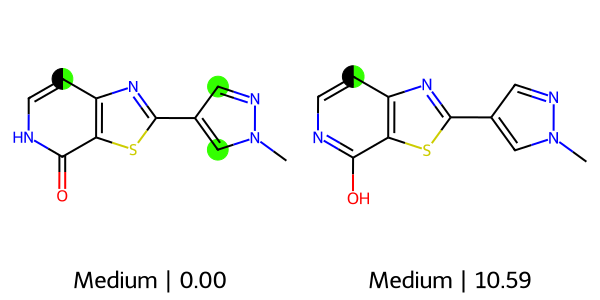

In [7]:
# DRAW A COMPOUND WITH HIGHLIGHTS
compound = 'comp585' # <--- select compound here!!
inp_smi = df.loc[compound]['input_smiles']
measured = df.loc[compound]['measured']
taut_smi = df.loc[compound]['taut_smiles']
pred_corr = df.loc[compound]['pred_corr']
pred_semi = df.loc[compound]['pred_semi']
prot_aff_list = [abs(min(x)) for x in df.loc[compound]['prot_energies']]
rel_taut_energies = np.array(df.loc[compound]['taut_energies']) - min(df.loc[compound]['taut_energies'])

labels = []
for i, prot_aff in enumerate(prot_aff_list):
    if prot_aff >= 100: #kcal/mol
        labels.append(f"High | {'{:.2f}'.format(rel_taut_energies[i])}")
    elif prot_aff <= 70: #kcal/mol
        labels.append(f"Low | {'{:.2f}'.format(rel_taut_energies[i])}")
    else:
        labels.append(f"Medium | {'{:.2f}'.format(rel_taut_energies[i])}")


SVG(molsvg.generate_structure(inp_smi, taut_smi, labels, [pred_corr, pred_semi], highlight_measure=measured))

In [8]:
# Find Corr, Semi, Fail for different tautomer cut-off
taut_cutoffs = np.arange(0,16,1) # kcal/mol

corr_count = []
semi_count = []
fail_count = []
total_count = []

for taut_cutoff in taut_cutoffs:
    corr = 0
    semi = 0
    fail = 0
    
    for index, row in df.iterrows():
        try:
            E_min = min(row.taut_energies)
        except:
            continue   
        rel_energies = np.array(row.taut_energies) - E_min
    
        pred_corr = row.pred_corr
        pred_semi = row.pred_semi
        measured = row.measured

        within_cutoff = np.where( rel_energies <= taut_cutoff )[0]

        pred_corr = list(filter(lambda x: pred_corr.index(x) in within_cutoff, pred_corr))
        pred_semi = list(filter(lambda x: pred_semi.index(x) in within_cutoff, pred_semi))

        pred_corr = np.unique(list(reduce(operator.concat, pred_corr)))
        pred_semi = np.unique(list(reduce(operator.concat, pred_semi)))

        if set(measured).issubset(pred_corr):
            corr += 1
        elif set(measured).issubset(pred_semi):
            semi += 1
        else:
            fail += 1

    corr_count.append(corr)
    semi_count.append(semi)
    fail_count.append(fail)
    total_count.append(corr+semi+fail)


print(f'Corr: {corr_count}')
print(f'Semi: {semi_count}')
print(f'Fail: {fail_count} \n')
print(f'Total: {total_count}')

Corr: [480, 481, 481, 481, 482, 483, 483, 483, 483, 484, 484, 486, 486, 488, 491, 491]
Semi: [28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 26, 26, 25, 23, 23]
Fail: [24, 23, 23, 23, 22, 21, 21, 21, 21, 20, 20, 20, 20, 19, 18, 18] 

Total: [532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532]


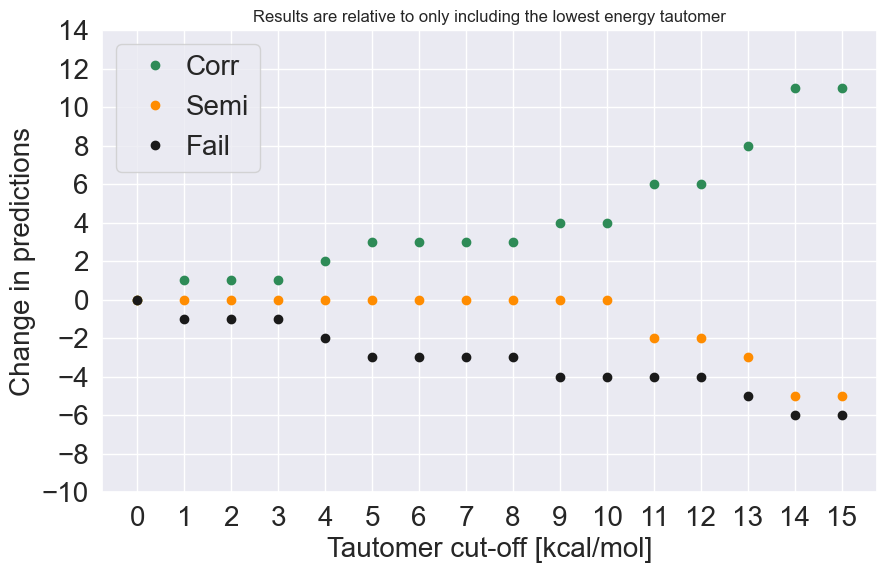

In [9]:
plt.plot(taut_cutoffs, np.array(corr_count)-corr_count[0], 'o', color="seagreen", label='Corr')
plt.plot(taut_cutoffs, np.array(semi_count)-semi_count[0], 'o', color="darkorange", label='Semi')
plt.plot(taut_cutoffs, np.array(fail_count)-fail_count[0], 'o', color="k", label='Fail')

plt.legend({'Corr': "seagreen", 'Semi': "darkorange", 'Fail': "k"}, fontsize=20, loc=2, handletextpad=0.1)

plt.xlabel('Tautomer cut-off [kcal/mol]', fontsize=20)
plt.xticks(taut_cutoffs, fontsize=20)

plt.ylabel('Change in predictions', fontsize=20)
plt.yticks(np.arange(-10,16,2), fontsize=20)

plt.title('Results are relative to only including the lowest energy tautomer', fontsize=12)

#plt.savefig('taut_cutoff.pdf', format='pdf')
plt.show()

In [10]:
# Avgerage time consumption
print(f"Min: {df.time_consumption.min()} {df.iloc[np.argmin(df.time_consumption.tolist())].name}")
print(f"Max: {df.time_consumption.max()} {df.iloc[np.argmax(df.time_consumption.tolist())].name}")
print(f"Mean: {df.time_consumption.mean()}")
print(f"Median: {df.time_consumption.median()}")

Min: 1.93 comp6
Max: 1845.32 comp373
Mean: 112.4000373831775
Median: 37.08


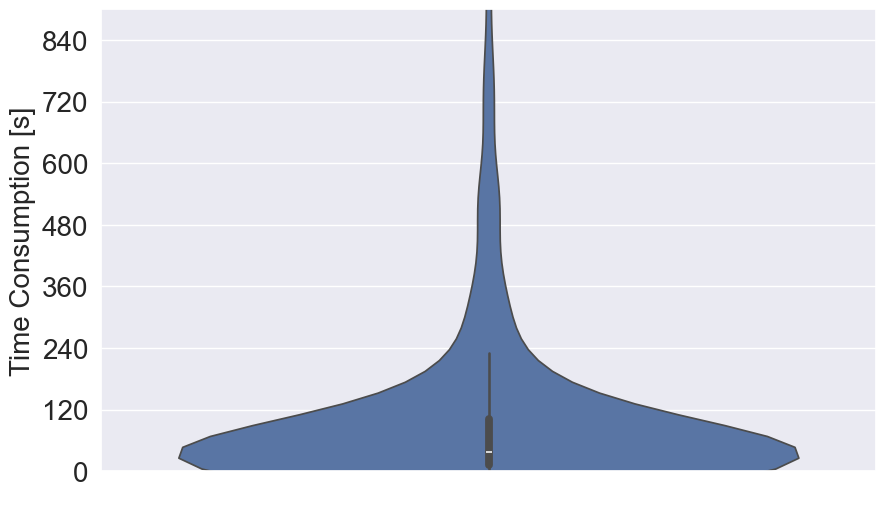

In [11]:
# Violin plot of time consumption
time_consump = df.time_consumption.tolist()

sns.violinplot(y=time_consump)
plt.xlabel(' ', fontsize=20)
plt.xticks([0], fontsize=20)

plt.ylabel('Time Consumption [s]', fontsize=20)
#plt.yticks(np.arange(0,max(time_consump)+2000,1000), fontsize=20)
plt.yticks(np.arange(0,max(time_consump)+2000,120), fontsize=20)
plt.ylim(0,900)
plt.show()

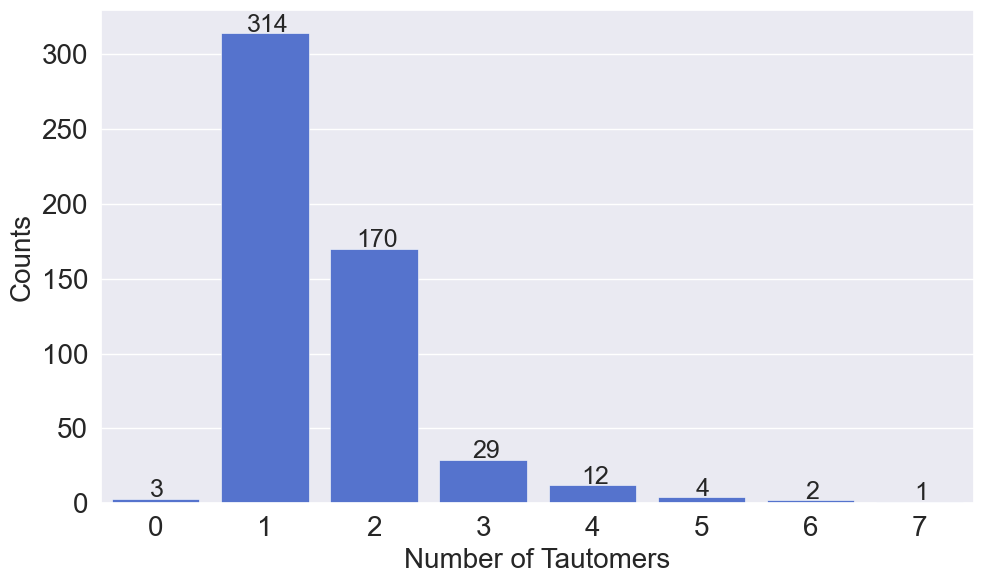

In [12]:
# Histogram over the number of tautomers below threshold of 15 kcal/mol
number_of_tautomers = []
for index, row in df.iterrows():
    number_of_tautomers.append(len(row.taut_smiles))

    
df_barchart = pd.DataFrame({'Number of Tautomers':list(set(number_of_tautomers)), 'Counts':np.unique(number_of_tautomers, return_counts=True)[1]})
ax = sns.barplot(x='Number of Tautomers', y='Counts', data=df_barchart, color='royalblue', edgecolor='w', linewidth=0.4)

for p in ax.patches:
    if p.get_height() < 10:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.35, p.get_height()+1), fontsize=18)
    elif p.get_height() < 100:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+1), fontsize=18)
    else:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.235, p.get_height()+1), fontsize=18)

plt.xlabel('Number of Tautomers', fontsize=20)
plt.ylabel('Counts', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('number_of_taut_histogram.pdf', format='pdf')
plt.show()

In [18]:
# HOW MANY TIMES ARE THE INPUT SMILES THE MOST STABLE WITH xTB?
input_lowest = 0
input_not_lowest = 0

for drug in drugs:
    input_smiles = drugs[drug]['input_smiles']
    if drugs[drug]['taut_smiles'] == []:
        continue
    taut_smiles = drugs[drug]['taut_smiles'][0] #they are sorted in according to the lowest energy of the deprotonated tautomer

    if Chem.MolToSmiles(Chem.MolFromSmiles(taut_smiles)) == Chem.MolToSmiles(Chem.MolFromSmiles(input_smiles)):
        input_lowest += 1
    else:
        input_not_lowest += 1

print('input lowest:', input_lowest)
print('input not lowest:', input_not_lowest)

input lowest: 514
input not lowest: 18


In [19]:
# HOW MANY TIMES ARE THE CANONICAL TAUTOMER THE MOST STABLE WITH xTB?
canon_lowest = 0
canon_not_lowest = 0
for drug in drugs:
    if drugs[drug]['taut_names'] == []:
        continue
    taut_name = drugs[drug]['taut_names'][0] #they are sorted in according to the lowest energy of the deprotonated tautomer
    
    if taut_name.split('_')[-1] == "t0":
        canon_lowest += 1
    else:
        canon_not_lowest += 1

print('Canon lowest:', canon_lowest)
print('Canon not lowest:', canon_not_lowest)

Canon lowest: 504
Canon not lowest: 28


In [15]:
# corr/semi/fail if one uses the canonical RDKit tautomers
corr = 0
semi = 0
fail = 0
    
for index, row in df.iterrows():
    name = row.name
    taut_names = row.taut_names
    taut_status = row.taut_status
    try:
        canon_taut = taut_names.index(f'{name}_t0')
        canon_taut_status = taut_status[canon_taut].lower()
    except:
        canon_taut_status = 'fail'
    
    if canon_taut_status == 'corr':
        corr += 1
    elif canon_taut_status == 'semi':
        semi += 1
    elif canon_taut_status == 'fail':
        fail +=1

print(f'Corr: {corr}')
print(f'Semi: {semi}')
print(f'Fail: {fail} \n')
print(f'Total: {corr+semi+fail}')

Corr: 290
Semi: 22
Fail: 223 

Total: 535


In [16]:
# CONFUSION MATRIX FOR THE WHOLE DATA SET - CORR
taut_cutoffs = np.arange(0,16,1) # kcal/mol

tp_count = []
fp_count = []
tn_count = []
fn_count = []
total_count = []

for taut_cutoff in taut_cutoffs:
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for index, row in df.iterrows():
        
        input_smiles = row.input_smiles
        input_mol = Chem.MolFromSmiles(input_smiles)
        
        taut_smiles = np.array(row.taut_smiles)
        taut_mols = [Chem.MolFromSmiles(smi) for smi in taut_smiles]
        taut_mols = get_atoms_in_order(input_mol, taut_mols)

        pred_corr = np.array(row.pred_corr)
        pred_semi = np.array(row.pred_semi)
        measured = np.array(row.measured)

        # Find tautomers below cutoff
        E_min = min(row.taut_energies)
        rel_energies = np.array(row.taut_energies) - E_min
        tauts_within_cutoff = np.where( rel_energies <= taut_cutoff )[0]

        # Locate unique EAS sites for all tautomers
        eas_sites_list = []
        for taut_idx in tauts_within_cutoff:
            tmol = taut_mols[taut_idx]
            eas_sites = np.sort(locate_sites(tmol)) # locate all EAS sites
            eas_sites = remove_identical_atoms(tmol, eas_sites) # include only unique sites
            eas_sites_list.extend(eas_sites)
            
        # Get predictions for tautomers below cutoff
        pred_corr = np.unique(reduce(operator.concat, pred_corr[tauts_within_cutoff].tolist())).tolist()
        pred_semi = np.unique(reduce(operator.concat, pred_semi[tauts_within_cutoff].tolist())).tolist()
        
        predicted = pred_corr #only include "Corr" predictions
        #predicted = pred_semi #only include "Semi" predictions

        # Confusion Matrix Analysis for unique atoms
        eas_sites = np.unique(eas_sites_list)
        for atom_site in eas_sites:
            if atom_site not in predicted and atom_site not in measured:
                tn += 1
            elif atom_site not in predicted and atom_site in measured:
                fn += 1
            elif atom_site in predicted and atom_site in measured:
                tp += 1
            elif atom_site in predicted and atom_site not in measured:
                fp += 1
        
    tp_count.append(tp)
    fp_count.append(fp)
    tn_count.append(tn)
    fn_count.append(fn)
    total_count.append(tn + fp + fn + tp)

print('tp:', tp_count[0], tp_count[-1])
print('fp:', fp_count[0], fp_count[-1])
print('tn:', tn_count[0], tn_count[-1])
print('fn:', fn_count[0], fn_count[-1])
print('total:', total_count[0], total_count[-1])

TypeError: remove_identical_atoms() missing 2 required positional arguments: 'smiles_list' and 'atom_list'

In [17]:
plt.plot(taut_cutoffs, np.array(tp_count)-tp_count[0], 'o', color="royalblue", label='TP')
plt.plot(taut_cutoffs, np.array(fp_count)-fp_count[0], 'o', color="darkorange", label='FP')
plt.plot(taut_cutoffs, np.array(tn_count)-tn_count[0], 'o', color="k", label='TN')
plt.plot(taut_cutoffs, np.array(fn_count)-fn_count[0], 'o', color="gold", label='FN')

plt.legend({'TP': "royalblue", 'FP': "darkorange", 'TN': "k", 'FN': "gold"}, fontsize=20, loc=2, handletextpad=0.1)

plt.xlabel('Tautomer cut-off [kcal/mol]', fontsize=20)
plt.xticks(taut_cutoffs, fontsize=20)

plt.ylabel('Change in predictions', fontsize=20)
plt.yticks(np.arange(-70,71,10), fontsize=20)

plt.title(f'Results are relative to only including the best tautomer: {tp_count[0]} (TP), {fp_count[0]} (FP), {tn_count[0]} (TN), {fn_count[0]} (FN)', fontsize=12)

#plt.savefig('taut_cutoff_confusion_corr.pdf', format='pdf')
plt.show()

IndexError: list index out of range

In [18]:
# CONFUSION MATRIX FOR THE WHOLE DATA SET - SEMI
taut_cutoffs = np.arange(0,16,1) # kcal/mol

tp_count = []
fp_count = []
tn_count = []
fn_count = []
total_count = []

for taut_cutoff in taut_cutoffs:
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    
    for index, row in df.iterrows():
        
        input_smiles = row.input_smiles
        input_mol = Chem.MolFromSmiles(input_smiles)
        
        taut_smiles = np.array(row.taut_smiles)
        taut_mols = [Chem.MolFromSmiles(smi) for smi in taut_smiles]
        taut_mols = get_atoms_in_order(input_mol, taut_mols)

        pred_corr = np.array(row.pred_corr)
        pred_semi = np.array(row.pred_semi)
        measured = np.array(row.measured)

        # Find tautomers below cutoff
        E_min = min(row.taut_energies)
        rel_energies = np.array(row.taut_energies) - E_min
        tauts_within_cutoff = np.where( rel_energies <= taut_cutoff )[0]

        # Locate unique EAS sites for all tautomers
        eas_sites_list = []
        for taut_idx in tauts_within_cutoff:
            tmol = taut_mols[taut_idx]
            eas_sites = np.sort(locate_sites(tmol)) # locate all EAS sites
            eas_sites = remove_identical_atoms(tmol, eas_sites) # include only unique sites
            eas_sites_list.extend(eas_sites)
            
        # Get predictions for tautomers below cutoff
        pred_corr = np.unique(reduce(operator.concat, pred_corr[tauts_within_cutoff].tolist())).tolist()
        pred_semi = np.unique(reduce(operator.concat, pred_semi[tauts_within_cutoff].tolist())).tolist()
        
        #predicted = pred_corr #only include "Corr" predictions
        predicted = pred_semi #only include "Semi" predictions

        # Confusion Matrix Analysis for unique atoms
        eas_sites = np.unique(eas_sites_list)
        for atom_site in eas_sites:
            if atom_site not in predicted and atom_site not in measured:
                tn += 1
            elif atom_site not in predicted and atom_site in measured:
                fn += 1
            elif atom_site in predicted and atom_site in measured:
                tp += 1
            elif atom_site in predicted and atom_site not in measured:
                fp += 1
        
    tp_count.append(tp)
    fp_count.append(fp)
    tn_count.append(tn)
    fn_count.append(fn)
    total_count.append(tn + fp + fn + tp)

print('tp:', tp_count[0], tp_count[-1])
print('fp:', fp_count[0], fp_count[-1])
print('tn:', tn_count[0], tn_count[-1])
print('fn:', fn_count[0], fn_count[-1])
print('total:', total_count[0], total_count[-1])

TypeError: remove_identical_atoms() missing 2 required positional arguments: 'smiles_list' and 'atom_list'

In [19]:
plt.plot(taut_cutoffs, np.array(tp_count)-tp_count[0], 'o', color="royalblue", label='TP')
plt.plot(taut_cutoffs, np.array(fp_count)-fp_count[0], 'o', color="darkorange", label='FP')
plt.plot(taut_cutoffs, np.array(tn_count)-tn_count[0], 'o', color="k", label='TN')
plt.plot(taut_cutoffs, np.array(fn_count)-fn_count[0], 'o', color="gold", label='FN')

plt.legend({'TP': "royalblue", 'FP': "darkorange", 'TN': "k", 'FN': "gold"}, fontsize=20, loc=2, handletextpad=0.1)

plt.xlabel('Tautomer cut-off [kcal/mol]', fontsize=20)
plt.xticks(taut_cutoffs, fontsize=20)

plt.ylabel('Change in predictions', fontsize=20)
plt.yticks(np.arange(-70,71,10), fontsize=20)

plt.title(f'Results are relative to only including the best tautomer: {tp_count[0]} (TP), {fp_count[0]} (FP), {tn_count[0]} (TN), {fn_count[0]} (FN)', fontsize=12)

#plt.savefig('taut_cutoff_confusion_semi.pdf', format='pdf')
plt.show()

IndexError: list index out of range

In [20]:
#HISTOGRAM OF PROTON AFFINITIES - For RegioSQM20 with xTB

corr_list = []
semi_list = []
fail_list = []
all_list = []

for index, row in df.iterrows():

    E_min = min(row.taut_energies)
    rel_energies = np.array(row.taut_energies) - E_min
    prot_energies = np.array(row.prot_energies)
    
    pred_corr = np.array(row.pred_corr)
    pred_semi = np.array(row.pred_semi)
    measured = np.array(row.measured)

    within_cutoff = np.where( rel_energies <= 0 )[0]
    pred_corr = np.unique(reduce(operator.concat, pred_corr[within_cutoff].tolist()))
    pred_semi = np.unique(reduce(operator.concat, pred_semi[within_cutoff].tolist()))

    prot_energies = abs(np.unique(reduce(operator.concat, prot_energies[within_cutoff].tolist()))[0])
    all_list.append(prot_energies)


    if set(measured).issubset(pred_corr):
        corr_list.append(prot_energies)
    elif set(measured).issubset(pred_semi):
        semi_list.append(prot_energies)
    else:
        fail_list.append(prot_energies)



print('Corr:', len(corr_list))
print('Semi:', len(semi_list))
print('Fail', len(fail_list))
print('Total', len(corr_list)+len(semi_list)+len(fail_list))
print(min(all_list), max(all_list))

# Stack the data
plt.figure()
#plt.xlabel('Absolute Proton Binding Energies [kcal/mol]', fontsize=20)
plt.xlabel('Proton Affinities [kcal/mol]', fontsize=20)
plt.ylabel('Counts', fontsize=20)
arr = plt.hist([corr_list,semi_list,fail_list], bins=np.arange(round(min(all_list),-1)-5,round(max(all_list),-1)+6, step=5), stacked=True, edgecolor='w', linewidth=0.4, color=["seagreen", "darkorange", "darkgrey"], density=False)
plt.legend({'Corr': "seagreen", 'Semi': "darkorange", 'Fail': "darkgrey"}, fontsize=20) 

for i in range(len(arr[1])-1):
    if int(arr[0][-1][i]) < 10:
        plt.text(int(arr[1][i]) + 1.8, arr[0][-1][i], str(int(arr[0][-1][i])), fontsize=20)
    elif int(arr[0][-1][i]) < 100:
        plt.text(float(arr[1][i]) + 1.15, arr[0][-1][i], str(int(arr[0][-1][i])), fontsize=20)
    else:
        plt.text(int(arr[1][i]) + 0.4, arr[0][-1][i], str(int(arr[0][-1][i])), fontsize=20)

plt.xlim((round(min(all_list),-1)-5,round(max(all_list),-1)+5))
plt.xticks(np.arange(round(min(all_list),-1)-5,round(max(all_list),-1)+6, step=5), fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('histogram_regiosqm20.pdf', format='pdf')
#plt.savefig('histogram_regiosqm20_cc1000.pdf', format='pdf')
#plt.savefig('histogram_regiosqm20_without_tauts.pdf', format='pdf')
#plt.savefig('histogram_regiosqm20_without_tauts_cc1000.pdf', format='pdf')
plt.show()   

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

Corr: 483
Semi: 27
Fail 25
Total 535
49.17616802630073 113.08526426349272


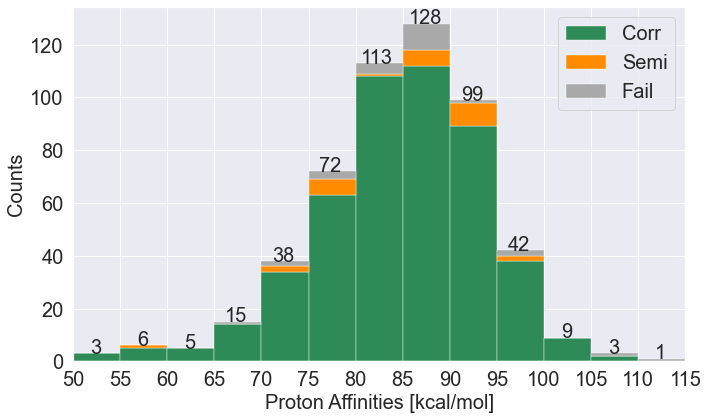

In [19]:
#HISTOGRAM OF PROTON AFFINITIES - For RegioSQM20 with PM3

corr_list = []
semi_list = []
fail_list = []
all_list = []

for index, row in df.iterrows():

    try:
        E_min = min(row.taut_energies)
    except:
        #prot_energies = np.array(row.prot_energies)
        #all_list.append(prot_energies)
        #fail_list.append(prot_energies)
        continue

    rel_energies = np.array(row.taut_energies) - E_min
    prot_energies = np.array(row.prot_energies)
    
    pred_corr = np.array(row.pred_corr)
    pred_semi = np.array(row.pred_semi)
    measured = np.array(row.measured)

    within_cutoff = np.where( rel_energies <= 0 )[0]
    pred_corr = np.unique(reduce(operator.concat, pred_corr[within_cutoff].tolist()))
    pred_semi = np.unique(reduce(operator.concat, pred_semi[within_cutoff].tolist()))

    prot_energies = abs(np.unique(reduce(operator.concat, prot_energies[within_cutoff].tolist()))[0])
    all_list.append(prot_energies)


    if set(measured).issubset(pred_corr):
        corr_list.append(prot_energies)
    elif set(measured).issubset(pred_semi):
        semi_list.append(prot_energies)
    else:
        fail_list.append(prot_energies)



print('Corr:', len(corr_list))
print('Semi:', len(semi_list))
print('Fail', len(fail_list))
print('Total', len(corr_list)+len(semi_list)+len(fail_list))
print(min(all_list), max(all_list))

# Stack the data
plt.figure()
#plt.xlabel('Absolute Proton Binding Energies [kcal/mol]', fontsize=20)
plt.xlabel('Proton Affinities [kcal/mol]', fontsize=20)
plt.ylabel('Counts', fontsize=20)
arr = plt.hist([corr_list,semi_list,fail_list], bins=np.arange(round(min(all_list),-1),round(max(all_list),-1)+6, step=5), stacked=True, edgecolor='w', linewidth=0.4, color=["seagreen", "darkorange", "darkgrey"], density=False)
plt.legend({'Corr': "seagreen", 'Semi': "darkorange", 'Fail': "darkgrey"}, fontsize=20) 

for i in range(len(arr[1])-1):
    if int(arr[0][-1][i]) < 10:
        plt.text(int(arr[1][i]) + 1.8, arr[0][-1][i], str(int(arr[0][-1][i])), fontsize=20)
    elif int(arr[0][-1][i]) < 100:
        plt.text(float(arr[1][i]) + 1.15, arr[0][-1][i], str(int(arr[0][-1][i])), fontsize=20)
    else:
        plt.text(int(arr[1][i]) + 0.6, arr[0][-1][i], str(int(arr[0][-1][i])), fontsize=20)

plt.xlim((round(min(all_list),-1),round(max(all_list),-1)))
plt.xticks(np.arange(round(min(all_list),-1),round(max(all_list),-1)+6, step=5), fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
#plt.savefig('histogram_regiosqm20_pm3.pdf', format='pdf')
#plt.savefig('histogram_regiosqm20_pm3_cc1000.pdf', format='pdf')
#plt.savefig('histogram_regiosqm20_pm3_without_tauts.pdf', format='pdf')
#plt.savefig('histogram_regiosqm20_pm3_without_tauts_cc1000.pdf', format='pdf')
plt.show()   